In [1]:
import numpy as np
import pandas as pd 



import os

In [2]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import feature, exposure
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects, skeletonize
from skimage.feature import local_binary_pattern, hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
# from imblearn.over_sampling import SMOTE
from scipy.stats import skew, kurtosis
from joblib import dump
import warnings

In [3]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    labels = []
    

    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        
       
        if os.path.isdir(label_folder):
            
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                
        
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
              
                if img is not None:
                 
                    img_resized = cv2.resize(img, target_size)
                    images.append(img_resized)
                    labels.append(label)  
    
    return images, labels


dataset_path = "D:\\Prayag Files\\TIET\\Extras\\hackathons\\analog\\Research Papers\\Mine\\Training"
images, labels = load_images_from_folder(dataset_path)


images = np.array(images)
labels = np.array(labels)


print(f"Number of images: {images.shape[0]}")
print(f"Image shape: {images.shape[1:]}")  
print(f"Number of labels: {len(labels)}")


Number of images: 2870
Image shape: (128, 128)
Number of labels: 2870


In [4]:

def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return np.array([clahe.apply(image) for image in images])


images_clahe = apply_clahe(images)

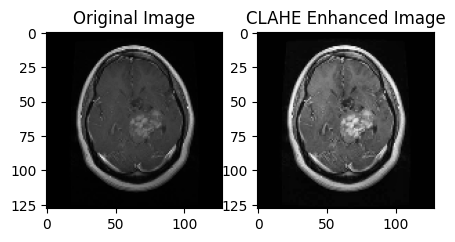

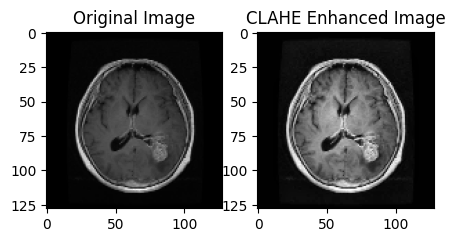

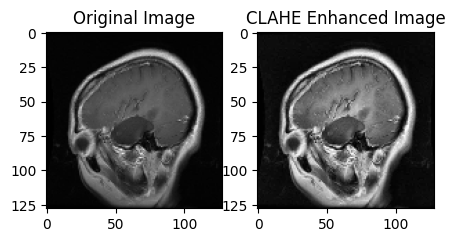

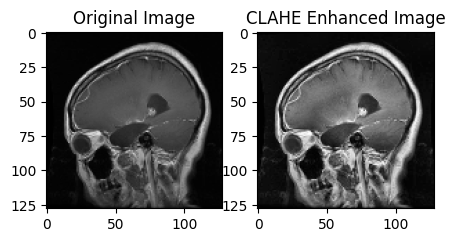

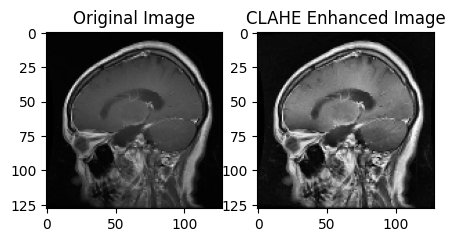

In [5]:

for i in range(5):
    plt.figure(figsize=(5, 5))


    plt.subplot(1, 2, 1)
    plt.imshow(images[i], cmap='gray')
    plt.title('Original Image')


    plt.subplot(1, 2, 2)
    plt.imshow(images_clahe[i], cmap='gray')
    plt.title('CLAHE Enhanced Image')

    plt.show()

In [6]:
def enhanced_region_growing(image, threshold=0.3):

    blurred = cv2.GaussianBlur(image, (5, 5), 0)


    _, otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_threshold = _ / 255.0

    final_threshold = (threshold + otsu_threshold) / 2


    labels = np.zeros_like(image)
    label_counter = 1

    seeds = np.where(image > final_threshold * image.max())

    for seed in zip(*seeds):
        if labels[seed] == 0:  
            seed_label = label(image > final_threshold * image.max())
            labels[seed_label == seed_label[seed]] = label_counter
            label_counter += 1

    return labels

segmented_images = [enhanced_region_growing(img) for img in images_clahe]

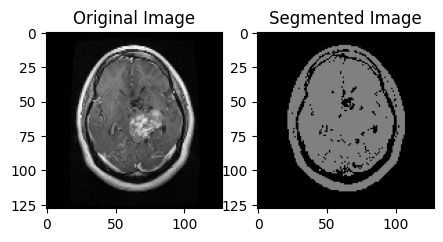

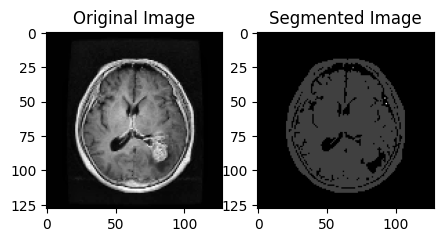

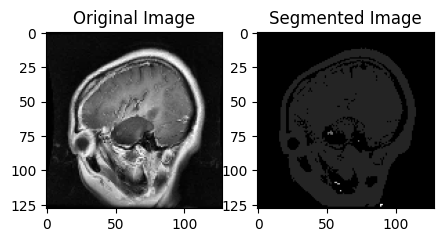

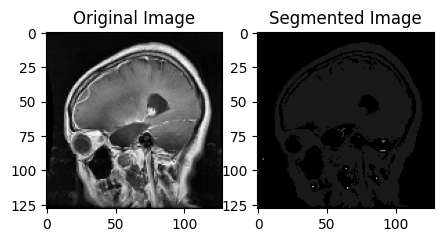

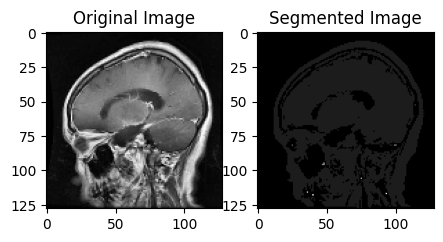

In [7]:

for i in range(5):
    plt.figure(figsize=(5, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(images_clahe[i], cmap='gray')
    plt.title('Original Image')


    plt.subplot(1, 2, 2)
    plt.imshow(segmented_images[i], cmap='gray')
    plt.title('Segmented Image')

    plt.show()

In [8]:
def enhanced_lbp(image, P=24, R=3):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

Validating Image 1


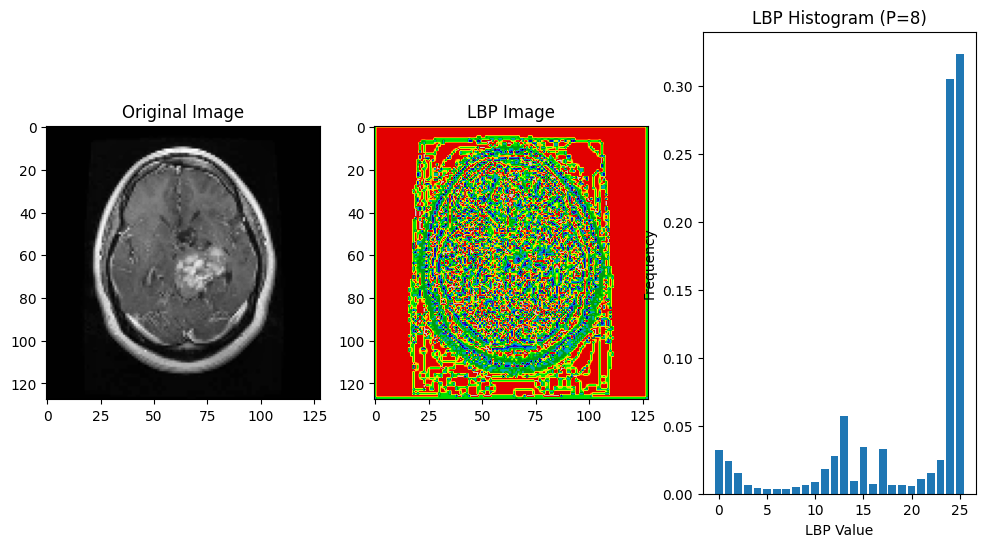

Validating Image 2


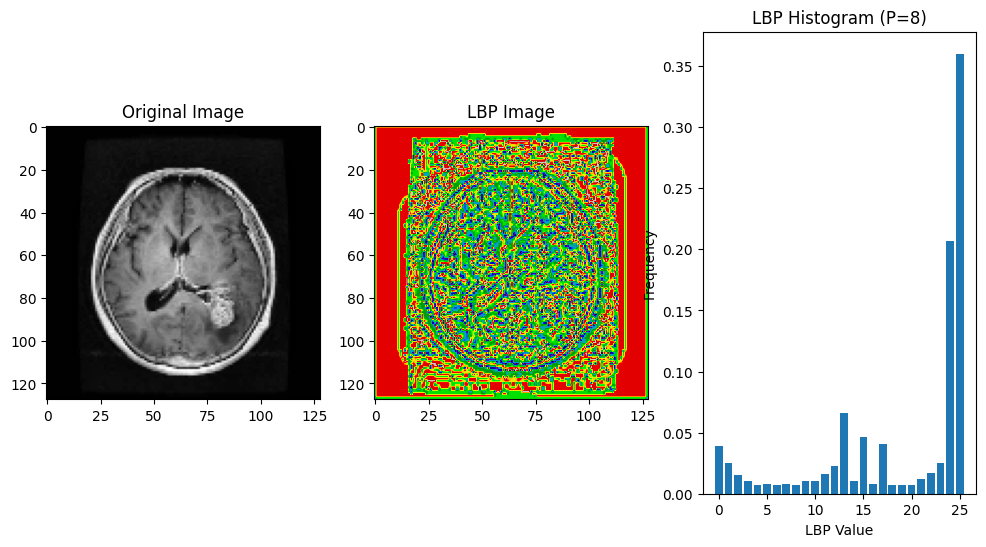

Validating Image 3


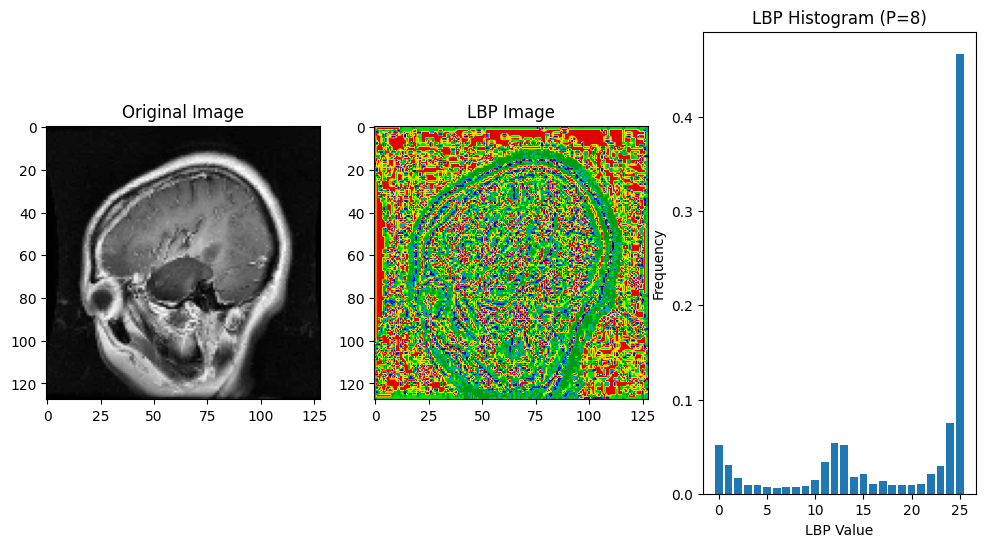

Validating Image 4


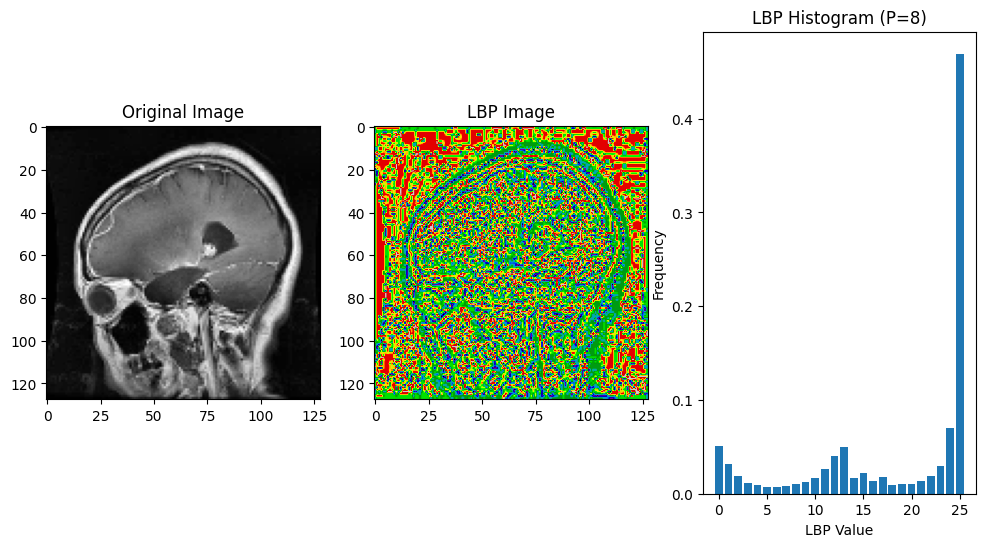

Validating Image 5


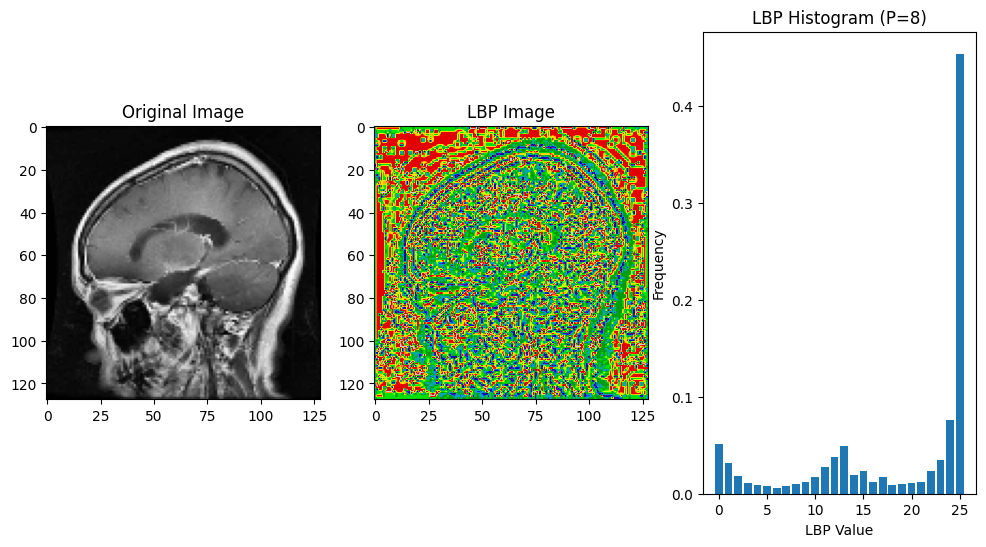

In [9]:
def visualize_lbp(lbp_histogram, image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')


    plt.subplot(1, 3, 2)
    plt.imshow(lbp, cmap='nipy_spectral')
    plt.title('LBP Image')
    
    plt.subplot(1, 3, 3)
    plt.bar(range(len(lbp_histogram)), lbp_histogram)
    plt.title(f'LBP Histogram (P={P})')
    plt.xlabel('LBP Value')
    plt.ylabel('Frequency')
    
    plt.show()



def validate_lbp_features(images):
    for idx, img in enumerate(images[:5]): 
        lbp_histogram = enhanced_lbp(img)

        print(f"Validating Image {idx + 1}")
        visualize_lbp(lbp_histogram,img, P=8, R=1)

validate_lbp_features(images_clahe)

Validating Image 1


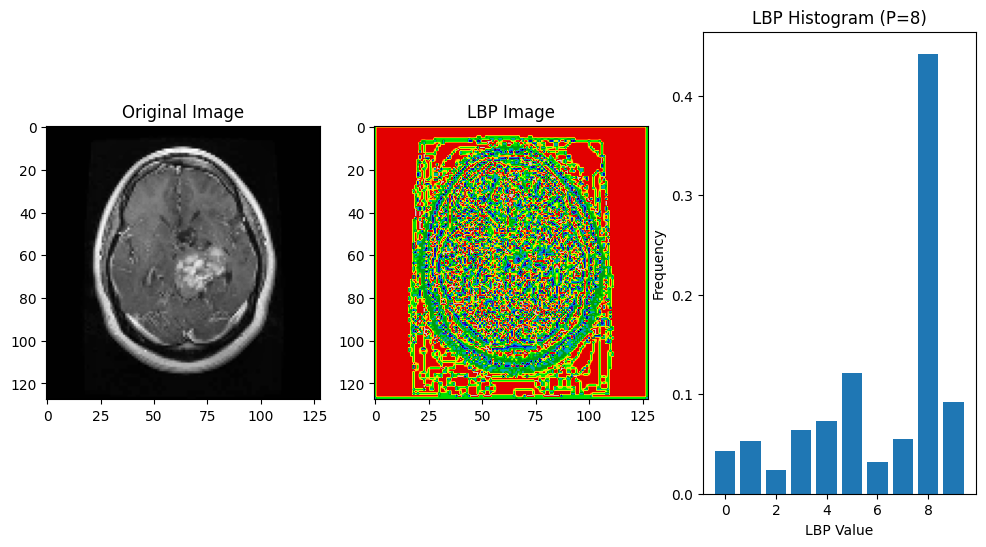

Validating Image 2


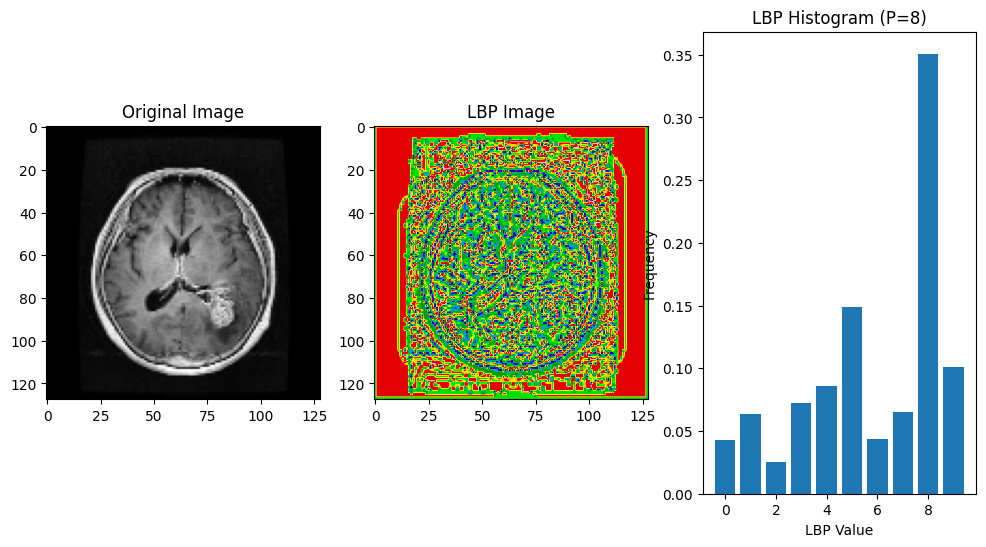

Validating Image 3


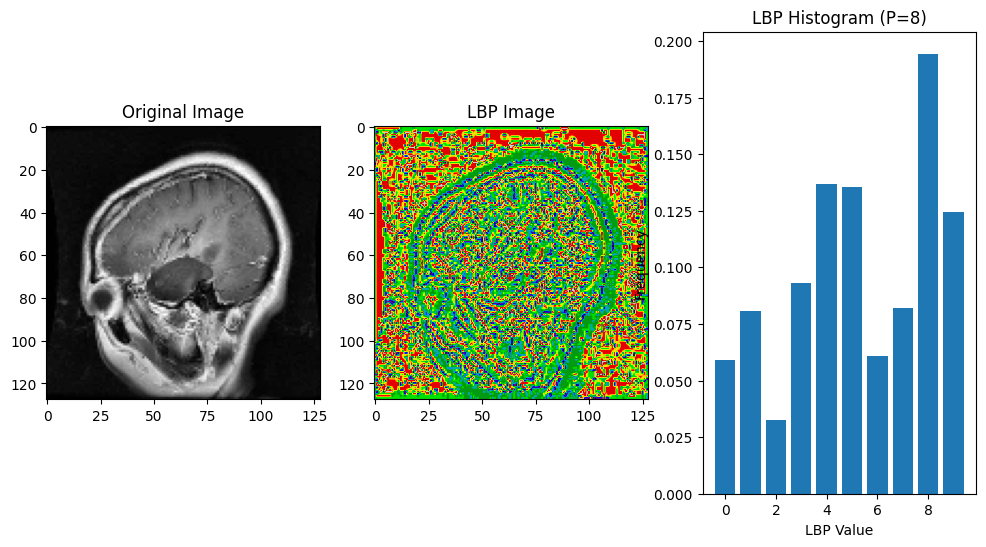

Validating Image 4


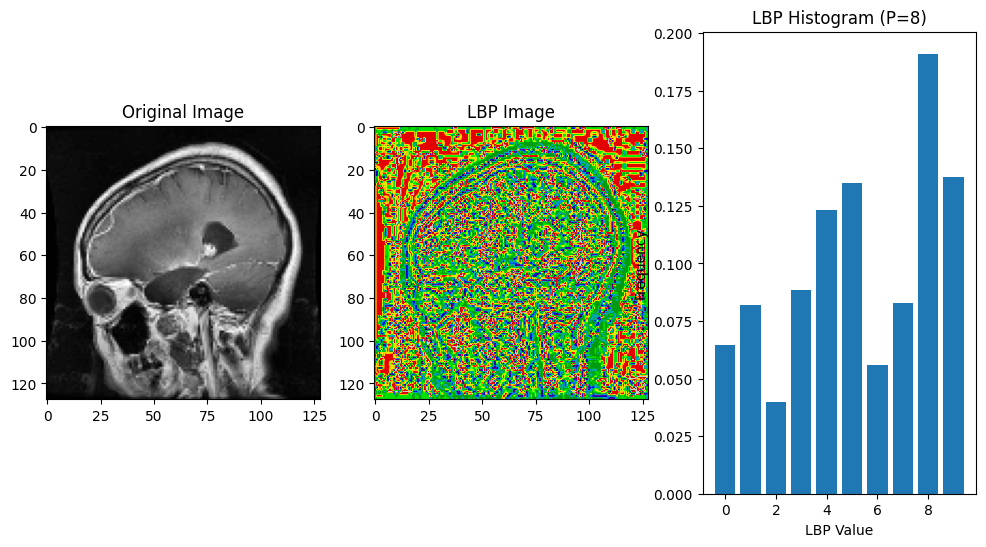

Validating Image 5


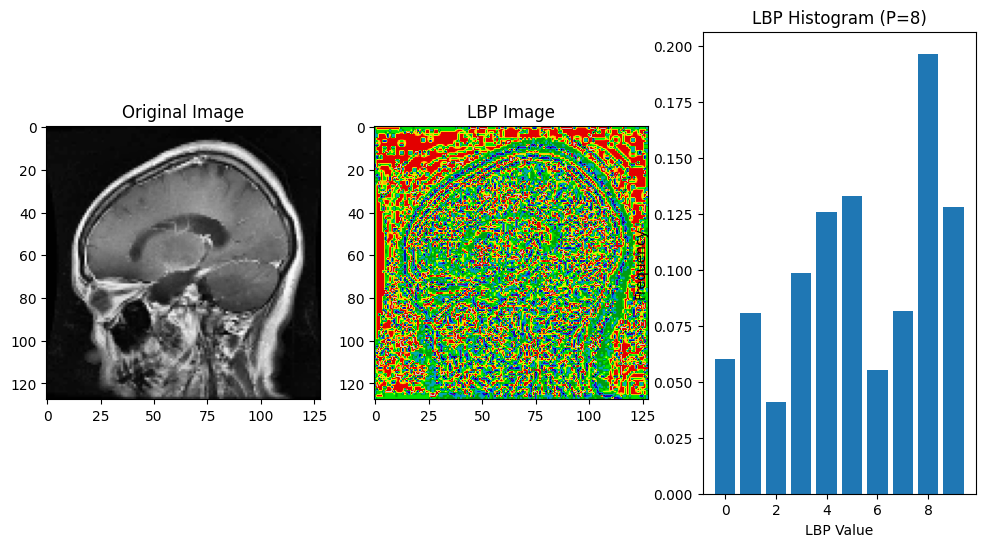

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern


def visualize_lbp(lbp_histogram, image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    plt.figure(figsize=(12, 6))


    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')


    plt.subplot(1, 3, 2)
    plt.imshow(lbp, cmap='nipy_spectral')
    plt.title('LBP Image')
    
    plt.subplot(1, 3, 3)
    plt.bar(range(len(lbp_histogram)), lbp_histogram)
    plt.title(f'LBP Histogram (P={P})')
    plt.xlabel('LBP Value')
    plt.ylabel('Frequency')
    
    plt.show()


def enhanced_lbp(image, P=8, R=1):
 
    equalized_image = cv2.equalizeHist(image)
    

    lbp = local_binary_pattern(equalized_image, P, R, method='uniform')
    

    n_bins = int(lbp.max() + 1)  
    lbp_histogram, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    
    return lbp_histogram


def validate_lbp_features(images):
    for idx, img in enumerate(images[:5]):  
        lbp_histogram = enhanced_lbp(img)

        # Visualization
        print(f"Validating Image {idx + 1}")
        visualize_lbp(lbp_histogram, img, P=8, R=1)


validate_lbp_features(images_clahe)


In [11]:
def enhanced_morphological_features(segmented_img, intensity_image):
    features = []
    labeled_img = label(segmented_img)
    skeleton = skeletonize(segmented_img)

    regions = regionprops(labeled_img, intensity_image=intensity_image)

    for region in regions:
        if region.area == 0 or region.perimeter == 0:
            continue


        solidity = region.solidity
        extent = region.extent
        euler_number = region.euler_number


        glcm = feature.graycomatrix(intensity_image[region.bbox[0]:region.bbox[2],
                                                   region.bbox[1]:region.bbox[3]],
                                    [1], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                                    symmetric=True, normed=True)
        contrast = feature.graycoprops(glcm, 'contrast').mean()
        dissimilarity = feature.graycoprops(glcm, 'dissimilarity').mean()
        homogeneity = feature.graycoprops(glcm, 'homogeneity').mean()
        energy = feature.graycoprops(glcm, 'energy').mean()
        correlation = feature.graycoprops(glcm, 'correlation').mean()

     
        intensities = intensity_image[region.coords[:, 0], region.coords[:, 1]]
        intensity_mean = np.mean(intensities)
        intensity_std = np.std(intensities)


        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                intensity_skewness = skew(intensities)
            except Warning:
                intensity_skewness = 0  

            try:
                intensity_kurtosis = kurtosis(intensities)
            except Warning:
                intensity_kurtosis = 0  

        feature_dict = {
            'Area': region.area,
            'Perimeter': region.perimeter,
            'Circularity': (4 * np.pi * region.area) / (region.perimeter ** 2 + 1e-10),
            'Eccentricity': region.eccentricity,
            'Major_Axis_Length': region.major_axis_length,
            'Minor_Axis_Length': region.minor_axis_length,
            'Solidity': solidity,
            'Extent': extent,
            'Euler_Number': euler_number,
            'Contrast': contrast,
            'Dissimilarity': dissimilarity,
            'Homogeneity': homogeneity,
            'Energy': energy,
            'Correlation': correlation,
            'Intensity_Mean': intensity_mean,
            'Intensity_Std': intensity_std,
            'Intensity_Skewness': intensity_skewness,
            'Intensity_Kurtosis': intensity_kurtosis,
        }

        features.append(feature_dict)

    return features

In [12]:
def calculate_hog(image):
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    return fd

In [13]:
def gabor_features(image):
    num_scales = 4
    num_orientations = 6
    gabor_responses = []

    for scale in range(num_scales):
        for orientation in range(num_orientations):
            frequency = 0.1 / (2 ** scale)
            theta = orientation * np.pi / num_orientations
            kernel = cv2.getGaborKernel((21, 21), 5, theta, frequency, 0.5, 0, ktype=cv2.CV_32F)
            filtered = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            gabor_responses.append(filtered.mean())
            gabor_responses.append(filtered.std())

    return np.array(gabor_responses)

In [14]:
def enhanced_extract_features(images, segmented_images):
    all_features = []
    feature_names = []

    for img, segmented_img in zip(images, segmented_images):

        lbp_hist = enhanced_lbp(img)


        hog_features = calculate_hog(img)

  
        gabor_feats = gabor_features(img)

   
        morph_features = enhanced_morphological_features(segmented_img, img)

        if not morph_features:  
            continue


        combined_features = np.concatenate([
            lbp_hist,
            hog_features,
            gabor_feats,
            list(morph_features[0].values())
        ])

        all_features.append(combined_features)

        if not feature_names:
            feature_names = (
                    [f'LBP_{i}' for i in range(len(lbp_hist))] +
                    [f'HOG_{i}' for i in range(len(hog_features))] +
                    [f'Gabor_{i}' for i in range(len(gabor_feats))] +
                    list(morph_features[0].keys())
            )

    return np.array(all_features), feature_names

SVM Accuracy: 0.9181184668989547
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       179
           1       0.86      0.89      0.88       169
           2       0.87      0.89      0.88        70
           3       0.94      0.98      0.96       156

    accuracy                           0.92       574
   macro avg       0.91      0.91      0.91       574
weighted avg       0.92      0.92      0.92       574

Random Forest Accuracy: 0.8310104529616724
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       179
           1       0.76      0.77      0.76       169
           2       0.72      0.83      0.77        70
           3       0.85      0.96      0.90       156

    accuracy                           0.83       574
   macro avg       0.82      0.83      0.82       574
weighted avg       0.84      0.83      0.83       574



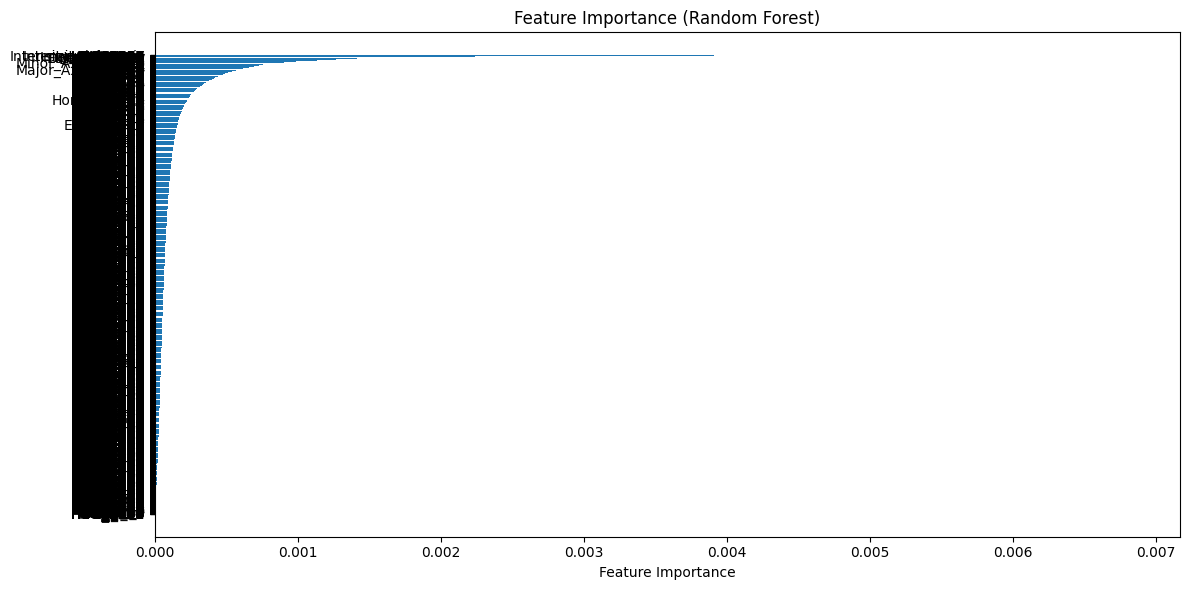

Best model saved as 'best_rf_model.joblib'
Script execution completed.


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np


from sklearn.utils.class_weight import compute_class_weight

if __name__ == "__main__":


    features, feature_names = enhanced_extract_features(images_clahe, segmented_images)

    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


    svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, class_weight='balanced')
    svm.fit(X_train_scaled, y_train)
    svm_pred = svm.predict(X_test_scaled)
    print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
    print(classification_report(y_test, svm_pred))


    rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight='balanced')
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)
    print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
    print(classification_report(y_test, rf_pred))


    feature_importance = rf.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(feature_names)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()


    dump(rf, 'best_rf_model.joblib')
    print("Best model saved as 'best_rf_model.joblib'")

    print("Script execution completed.")


In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.over_sampling import SMOTE
# from joblib import dump
# import seaborn as sns
# from tqdm import tqdm

# # Function to plot confusion matrix
# def plot_confusion_matrix(cm, class_names, title):
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title(title)
#     plt.show()

# # Function to plot ROC curve
# def plot_roc_curve(y_test, y_pred, title):
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred):.2f})')
#     plt.plot([0, 1], [0, 1], 'k--', lw=2)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(title)
#     plt.legend(loc='lower right')
#     plt.grid()
#     plt.show()

# if __name__ == "__main__":
   
#     # Extract features (assuming images_clahe, segmented_images, and labels are preloaded)
#     print("Extracting features...")
#     features, feature_names = enhanced_extract_features(images_clahe, segmented_images)

#     # Encode labels
#     print("Encoding labels...")
#     le = LabelEncoder()
#     encoded_labels = le.fit_transform(labels)

#     # Split data
#     print("Splitting data into training and test sets...")
#     X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

#     # Feature scaling
#     print("Applying feature scaling...")
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Apply SMOTE to handle class imbalance
#     print("Applying SMOTE for class balancing...")
#     smote = SMOTE(random_state=42)
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

#     # Track training progress
#     print("Training models...")

#     # SVM Training
#     print("Training Support Vector Machine (SVM)...")
#     svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
#     svm.fit(X_train_resampled, y_train_resampled)
#     svm_pred = svm.predict(X_test_scaled)
#     svm_accuracy = accuracy_score(y_test, svm_pred)
#     print("SVM Accuracy:", svm_accuracy)
#     print(classification_report(y_test, svm_pred))

#     # Plot SVM Confusion Matrix
#     cm_svm = confusion_matrix(y_test, svm_pred)
#     plot_confusion_matrix(cm_svm, le.classes_, "SVM Confusion Matrix")

#     # Plot SVM ROC Curve
#     plot_roc_curve(y_test, svm_pred, "SVM ROC Curve")

#     # Random Forest Training
#     print("Training Random Forest Classifier...")
#     rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
#     rf.fit(X_train_resampled, y_train_resampled)
#     rf_pred = rf.predict(X_test_scaled)
#     rf_accuracy = accuracy_score(y_test, rf_pred)
#     print("Random Forest Accuracy:", rf_accuracy)
#     print(classification_report(y_test, rf_pred))

#     # Plot Random Forest Confusion Matrix
#     cm_rf = confusion_matrix(y_test, rf_pred)
#     plot_confusion_matrix(cm_rf, le.classes_, "Random Forest Confusion Matrix")

#     # Plot Random Forest ROC Curve
#     plot_roc_curve(y_test, rf_pred, "Random Forest ROC Curve")

#     # Plot Feature Importance for Random Forest
#     print("Plotting feature importance...")
#     feature_importance = rf.feature_importances_
#     sorted_idx = np.argsort(feature_importance)
#     pos = np.arange(sorted_idx.shape[0]) + .5

#     plt.figure(figsize=(12, 6))
#     plt.barh(pos, feature_importance[sorted_idx], align='center')
#     plt.yticks(pos, np.array(feature_names)[sorted_idx])
#     plt.xlabel('Feature Importance')
#     plt.title('Feature Importance (Random Forest)')
#     plt.tight_layout()
#     plt.show()

#     # Save the best model
#     dump(rf, 'best_rf_model.joblib')
#     print("Best model saved as 'best_rf_model.joblib'")

#     print("Script execution completed.")


ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (c:\Users\Prayag Chawla\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py)